In [24]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import rc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, mean_squared_error

import time


from sklearn.feature_selection import SelectFromModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from shrink_functions import X_y, ss
from model_functions import model_clusters, plot_rmse, clust_grid, class_crossval_plot
from clust_functions import kmeans, elbow_plot, silhouette_plot, heir_clust

In [5]:
%matplotlib inline
pd.set_option('max_columns',500)
font = {'size': 20}
rc('font', **font)
plt.style.use('seaborn-dark-palette')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
df = pd.read_pickle('../data/SRP/clean_data_public_no_crime_lag2_by_cat.pkl')

In [4]:
cust_table_clust = pd.read_pickle('data/SRP/cust_table_clusters_biased.pkl')
df = df.join(cust_table_clust, on='address1', how='left')

# Split into features vs targets

In [9]:
# split into features and targets
non_feature_cols = ['shrink_value', 'shrink_to_sales_value_pct', 'shrink_value_out', 'shrink_to_sales_value_pct_out',
               'shrink_value_ex_del', 'shrink_to_sales_value_pct_ex_del', 'qty_inv_out', 'qty_shrink',
               'qty_shrink_ex_del', 'qty_shrink_out', 'qty_end_inventory', 'qty_f', 'qty_out', 'qty_ex_del',
               'qty_n', 'qty_delivery', 'qty_o', 'qty_d', 'qty_shrink_per_day', 'shrink_value_per_day', 'qty_start_inventory']
X, y = X_y(df, non_feature_cols, target_col='shrink_value_per_day')
# del df # free up memory

# random split for model testing (try/except based on customer seg being completed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize and Scale

In [10]:
# save off non-scaled version (for naive comparison)
X_train_ns = X_train
X_test_ns = X_test

# standardize and scale data
X_train = ss(X_train, std=True, scale=True)
X_test = ss(X_test, std=True, scale=True)

In [11]:
X_train.head()

,FD_ratio,LAPOP1_10,POP2010,address1,address2,city,creation_date,creation_date_int,customer_id,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,customer_id_3097348,dens_sq_mile,item_UPC,item_category,item_category_10,item_category_16,item_category_19,item_category_26,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_8,item_category_90,item_description,item_id,last_edit_date,last_edit_date_int,list_header_id,old_item_UPC,old_item_id,prev_item_move_date,prev_item_move_date_int,prev_visit_date,prev_visit_date_int,qty_POG_limit,qty_prev_end_inventory,qty_sales,qty_shrink_per_day_lag1_by_cat,qty_shrink_per_day_lag2_by_cat,sales_rep_id,sales_rep_id_2,sales_value,ship_id,ship_list_pk,shrink_value_per_day_lag1_by_cat,shrink_value_per_day_lag2_by_cat,state,unemp_rate,unit_price,visit_date,visit_date_int,zip_code
3151591,-0.338694,-0.893583,-0.524056,SPEEDWAY #5163,2350 W ALTO RD,KOKOMO,2016-08-23 07:37:37,0.000000,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.425079,71941020001,44,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5 HR-GRAPE (218123),1437114,2016-08-23 07:37:38,0.000000,3386280,71941020001,1437114,2017-12-12,0.944414,2017-12-12,0.944414,0.626357,0.671195,0.114359,0.301759,0.327103,100040113,100040113,-0.167498,119218,139188,-0.124989,-0.109570,IN,0.767576,-1.142428,2018-01-03,0.988089,46902
3240526,1.985210,-0.527506,-0.472507,SPEEDWAY #6384,201 E MAIN ST,DANVILLE,2016-08-23 07:37:37,0.000000,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.571155,71941074001,44,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5 HR-XSTRENGTH STRAWBERRY WATERMELON,2145131,2016-08-23 07:37:38,0.000000,3386280,71941074001,2145131,2017-12-01,0.922577,2017-12-01,0.922577,3.927439,4.058466,0.114359,0.944809,0.981956,100020116,100020116,-0.127804,119317,138015,0.204732,0.208206,IN,-1.361043,-1.099118,2017-12-15,0.950370,46122
1548133,1.135155,0.135972,-0.242008,SPEEDWAY #8591,2456 W GRAND BLANC RD,GRAND BLANC,2017-02-27 20:24:26,0.374361,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.349342,8079841049,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ELEC-SR DUAL USB CAR CHARGER 3.1A-BULK,2221135,2017-09-09 09:00:38,0.758466,3386280,8079841049,2221135,2017-08-18,0.714047,2017-08-18,0.714047,-0.033859,-0.006259,-0.062926,-0.303465,-0.058105,100269114,100020111,0.384334,119422,171343,-0.307369,-0.093002,MI,0.159399,-0.039283,2017-09-01,0.741840,48439
1147293,1.551535,1.045053,-0.035002,SPEEDWAY #7613,12007 159TH ST,HOMER GLEN,2016-08-23 07:37:37,0.000000,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.359909,5254860394,58,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,IGEAR BROWN JERSEY,2975450,2016-08-23 07:37:38,0.000000,3386280,60870758910,5754,2017-07-17,0.650520,2017-07-17,0.650520,-0.363967,-0.344986,-0.417495,-0.303465,-0.289229,100034112,100034112,-0.534089,118776,137479,-0.307369,-0.285342,IL,-1.056954,-1.111856,2017-07-31,0.678313,60491
3037778,1.449668,-0.338440,-0.402954,SPEEDWAY #3529,34740 EUCLID AVE,WILLOUGHBY,2016-12-23 10:00:33,0.242475,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.358502,60870712960,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,PUGS-PR5 PREMIUM 24.99,2627148,2016-12-23 10:00:34,0.242475,3386280,60870712960,2627148,2017-07-31,0.678313,2017-11-20,0.900739,-0.639057,-0.627258,-0.417495,-0.227812,-0.086995,100269117,100269117,-0.534089,119522,169380,-0.029875,0.055036,OH,-1.056954,1.323725,2017-12-04,0.928532,44094


In [12]:
# create mask of all numberical columns to be used in clustering/modeling

# including time features
numb_mask = (X_train.dtypes == int) | (X_train.dtypes == np.float64) | (X_train.dtypes == np.float32) | (X_train.dtypes == np.uint8)
numb_cols = X_train.columns[numb_mask]

# not including time features
numb_no_time_mask = (X_train.dtypes == int) | (X_train.dtypes == np.float64) | (X_train.dtypes == np.uint8)
numb_no_time_cols = X_train.columns[numb_no_time_mask]

# forcasting columns (what is known months ahead of time)
forc_cols = ['FD_ratio', 'LAPOP1_10', 'POP2010', 'customer_id_1635139',
             'customer_id_1903139', 'customer_id_2139', 'customer_id_2331150',
             'customer_id_2741156', 'customer_id_2773156', 'customer_id_2782156',
             'customer_id_2956160', 'customer_id_2977160', 'customer_id_3083182',
             'customer_id_3088198', 'customer_id_3088201', 'customer_id_3089336',
             'customer_id_3093327', 'customer_id_3093329', 'customer_id_3097348',
             'dens_sq_mile', 'shrink_value_per_day_lag1', 'shrink_value_per_day_lag2', 'unemp_rate']
# mask to be used in calculations
model_mask_cols = numb_no_time_cols

## Heirarchal Clustering

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:704: RuntimeWarning: invalid value encountered in greater_equal
  if np.all(y >= 0) and np.allclose(y, y.T):


ValueError: The condensed distance matrix must contain only finite values.

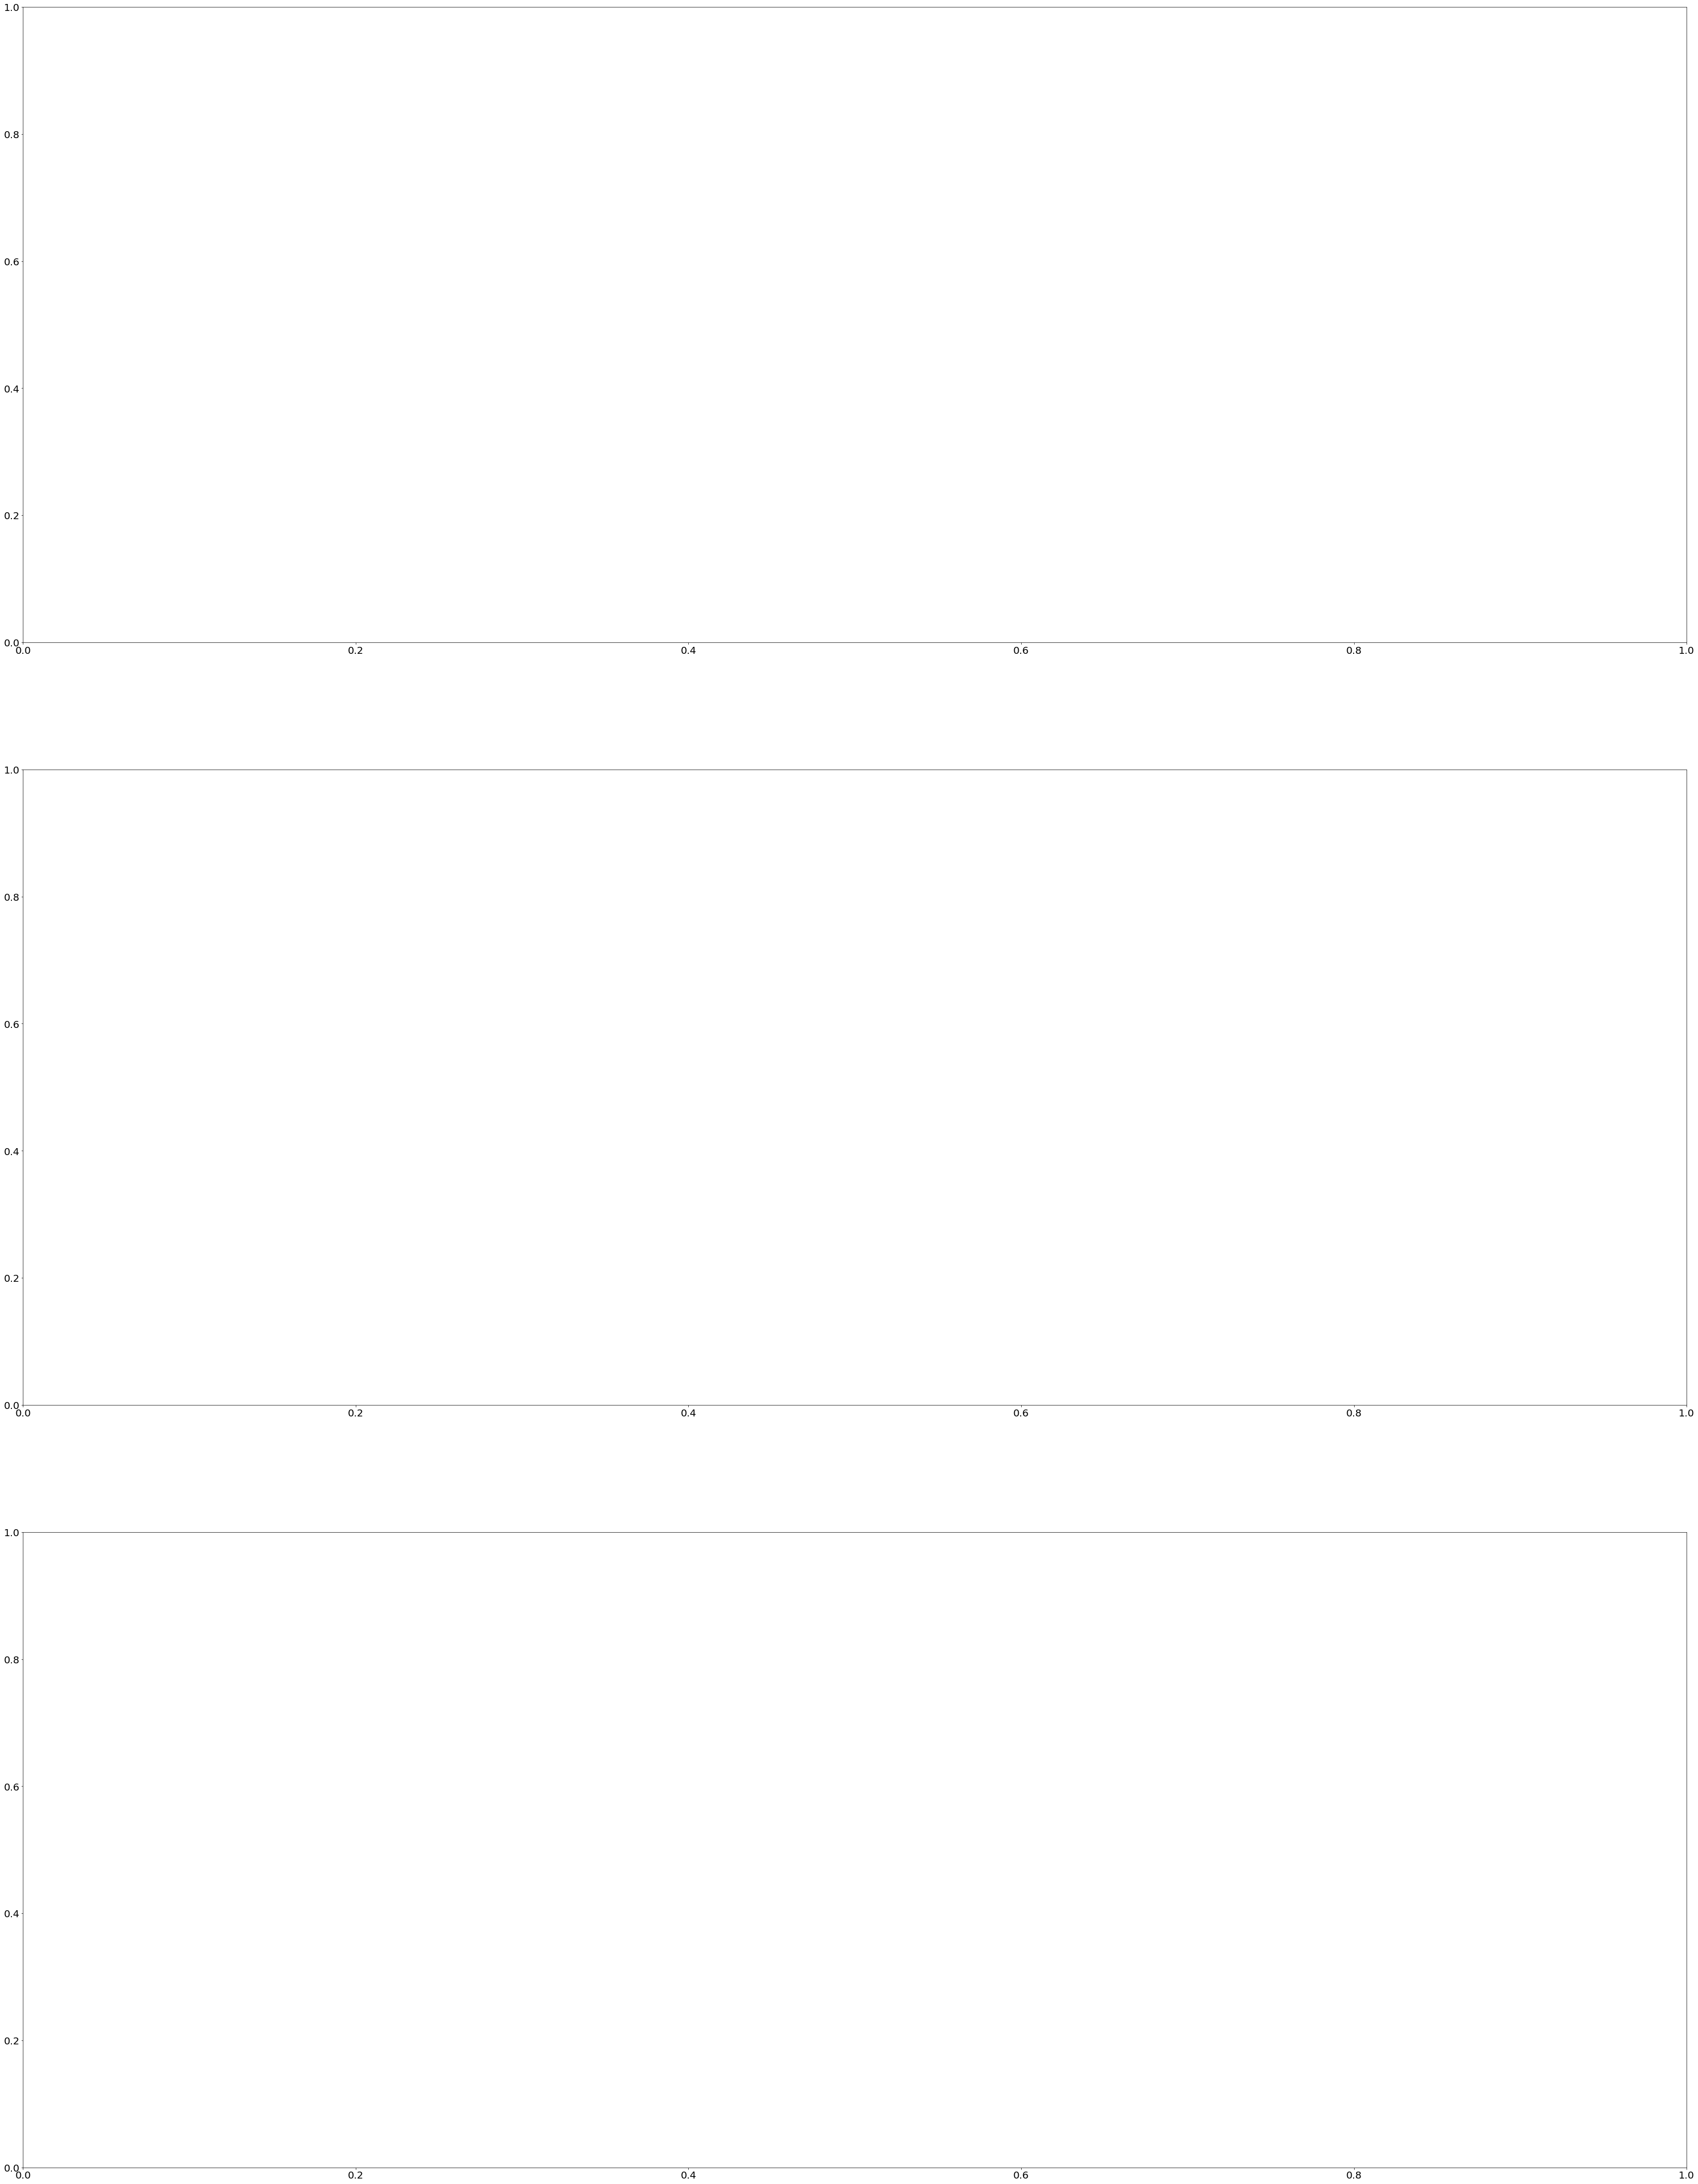

In [12]:
heir_clust(X_train[model_mask_cols], thresh=1.6)

## multiple Sklear models

Mod - Avg - Std Dev
---   ---   -------
Linear Regression: -0.48 (0.014422)
Ridge Regression: -0.48 (0.014420)
Lasso Regression: -0.57 (0.013231)
Elastic Net: -0.57 (0.013231)
K Nearest Neighbors: -0.48 (0.014065)
Decision Tree: -0.60 (0.025342)
Random Forest: -0.46 (0.020020)
Gradient Boost: -0.43 (0.013737)
Multi-Layer Perceptron: -0.44 (0.019064)


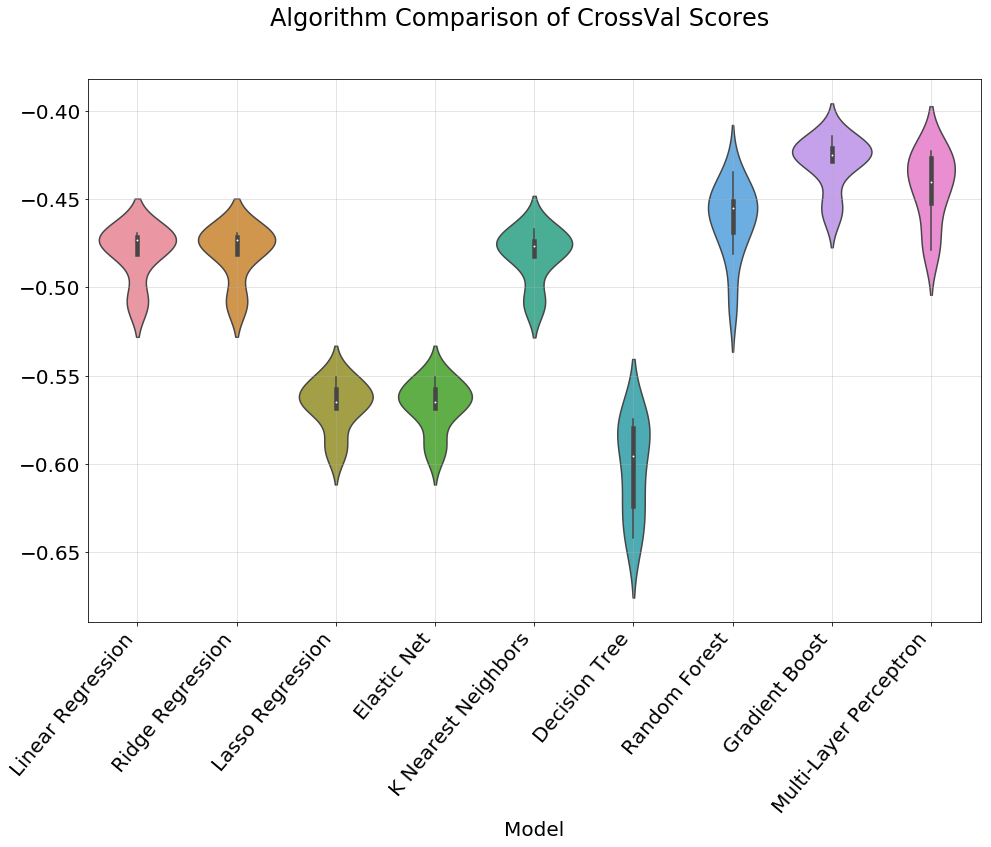

In [25]:
# Initial Cross Validation
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge Regression', Ridge()))
models.append(('Lasso Regression', Lasso()))
models.append(('Elastic Net', ElasticNet()))
models.append(('K Nearest Neighbors', KNeighborsRegressor(n_jobs=-1)))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
models.append(('Gradient Boost', GradientBoostingRegressor()))
models.append(('Multi-Layer Perceptron', MLPRegressor(alpha=0.001, solver='adam', activation='relu', hidden_layer_sizes=(100,))))

class_crossval_plot(X_train[model_mask_cols], y_train, models)

Mod - Avg - Std Dev
---   ---   -------
Linear Regression: -0.48 (0.014422)
Ridge Regression: -0.48 (0.014420)
Lasso Regression: -0.57 (0.013231)
Elastic Net: -0.57 (0.013231)
K-Nearest Neighbors: -0.48 (0.014065)
Decision Tree: -0.60 (0.025342)
Random Forest: -0.46 (0.020020)
Gradient Boost: -0.43 (0.013737)
Multi-Layer Perceptron: -0.45 (0.016154)


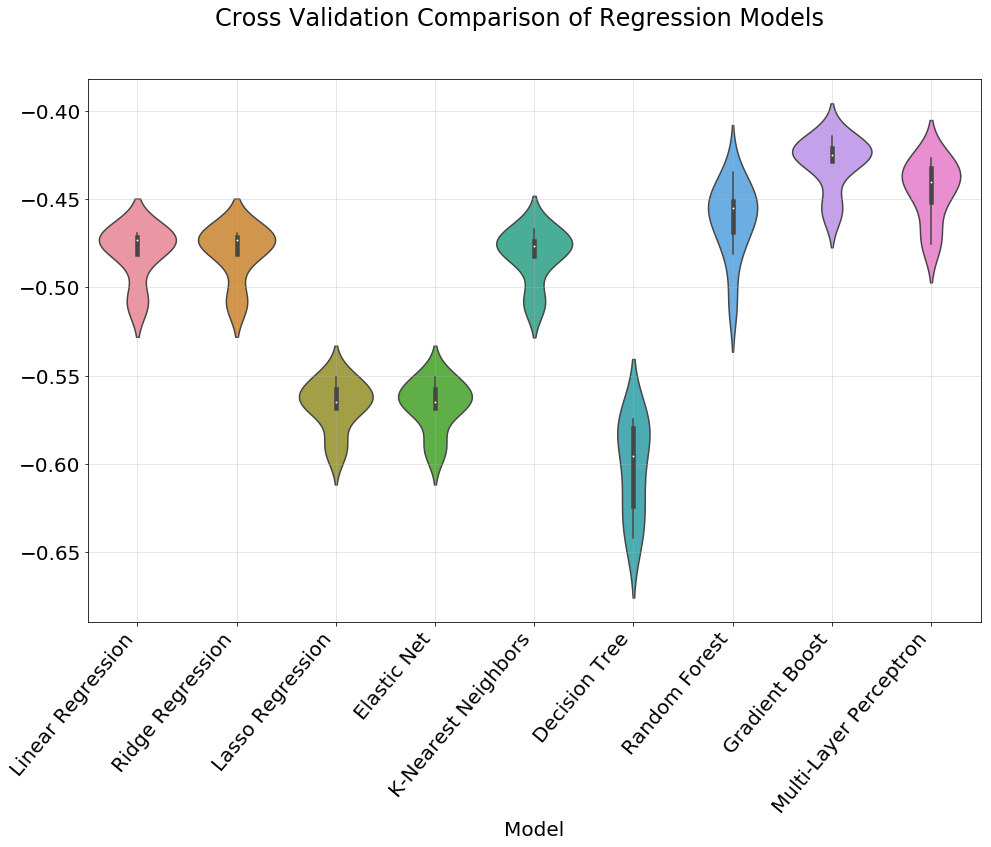

In [27]:
# Initial Cross Validation
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge Regression', Ridge()))
models.append(('Lasso Regression', Lasso()))
models.append(('Elastic Net', ElasticNet()))
models.append(('K-Nearest Neighbors', KNeighborsRegressor(n_jobs=-1)))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
models.append(('Gradient Boost', GradientBoostingRegressor()))
models.append(('Multi-Layer Perceptron', MLPRegressor()))

class_crossval_plot(X_train[model_mask_cols], y_train, models)

# Splitting By Cluster

Average:  0.40561269029072144
Std. Dev.:  1.532391323064075


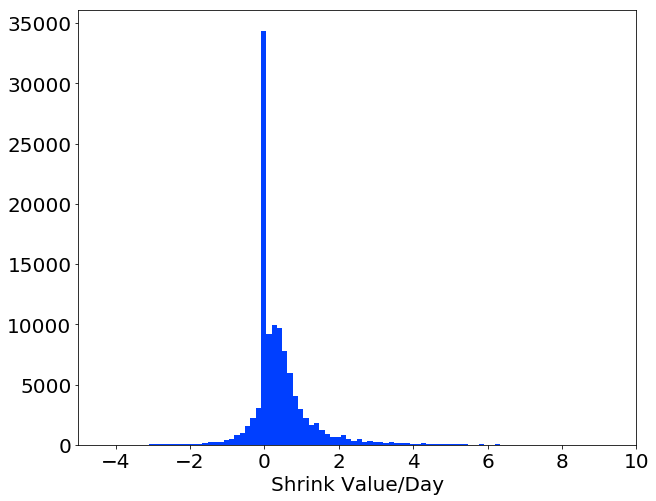

In [8]:
value_dist = df.shrink_value_per_day.values
plt.figure(figsize=(10,8))
plt.hist(value_dist, bins=2000)
#plt.yscale('log')
plt.xlim(xmin=-5, xmax=10)
plt.xlabel('Shrink Value/Day')

print('Average: ', value_dist.mean())
print('Std. Dev.: ',value_dist.std())

In [13]:
X_train.groupby('cluster').count()

,FD_ratio,LAPOP1_10,POP2010,address1,address2,city,creation_date,creation_date_int,customer_id,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,customer_id_3097348,dens_sq_mile,item_UPC,item_category,item_category_10,item_category_16,item_category_19,item_category_26,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_8,item_category_90,item_description,item_id,last_edit_date,last_edit_date_int,list_header_id,old_item_UPC,old_item_id,prev_item_move_date,prev_item_move_date_int,prev_visit_date,prev_visit_date_int,qty_POG_limit,qty_prev_end_inventory,qty_sales,qty_shrink_per_day_lag1_by_cat,qty_shrink_per_day_lag2_by_cat,qty_start_inventory,sales_rep_id,sales_rep_id_2,sales_value,ship_id,ship_list_pk,shrink_value_per_day_lag1_by_cat,shrink_value_per_day_lag2_by_cat,state,unemp_rate,unit_price,visit_date,visit_date_int,zip_code
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194
1,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826
2,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120
3,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201


## LSTM

In [ ]:
def fit_lstm(X, y, batch_size, nb_epoch, neurons):
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# repeat experiment
repeats = 1
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(X_train[model_mask_cols], y_train, 1, 3, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
 
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

# Forcasting/Time Series
 - Inclusion of endog (target) variable into predictive model/forcast
 - Explore various techniques outlined statsmodels.pdf
 - Try LSTM neural net

In [ ]:
plt.scatter(X_train.prev_item_move_date_int.values, X_train.prev_visit_date_int.values, alpha=0.01)

In [ ]:
foo = df[ df.address1 == 'SPEEDWAY #1224']
plt.figure(figsize=(12,12))
plt.scatter(foo.visit_date.values, foo.qty_shrink.values, c=foo.item_UPC.values)
plt.xticks(rotation=45)
plt.legend()

In [ ]:
def cat_plot_sales():
    freq = '2w'
    item_filt = df.groupby(['item_category', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(12,12))
    i = 1
    for cat in item_filt.item_category.unique():
        if cat == '41':
            continue
        foo = item_filt[ item_filt.item_category == cat]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.sales_value, label=cat)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Lost Sales/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Sales Loss Across All Stores by Cat')
    
cat_plot_sales()

In [ ]:
def cat_plot_shrink():
    freq = '2w'
    item_filt = df.groupby(['item_category', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(12,12))
    i = 1
    for cat in item_filt.item_category.unique():
        if cat == '41':
            continue
        foo = item_filt[ item_filt.item_category == cat]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.qty_shrink, label=cat)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Shrink/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Shrink Loss Across All Stores by Cat')
    
    
cat_plot_shrink()

In [ ]:
def st_plot_sales():
    freq = '20d'
    item_filt = df.groupby(['state', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(40,60))
    i = 1
    count = 0
    for state in item_filt.state.unique():
        count += 1
        if count % 9 == 0:
            i += 1
        foo = item_filt[ item_filt.state == state]
        ax = fig.add_subplot(3,2,i)
        ax.plot(foo.visit_date, foo.sales_value, label=state)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
        ax.legend()
        ax.set_ylabel('Average Lost Sales/{} ($)'.format(freq))
        ax.set_xlabel('Date')
        ax.grid(alpha=0.3)
        ax.set_title('Average Sales Loss Across Cat by State')
    
st_plot_sales()

In [ ]:
def cust_plot_sales():
    freq = '2w'
    item_filt = df.groupby(['customer_id', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(16,10))
    plt.tight_layout()
    i = 1
    for cust in item_filt.customer_id.unique():
        if cust == '2741156':
            continue
        foo = item_filt[ item_filt.customer_id == cust]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.sales_value, label=cust)
        #ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Lost Sales/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Sales Loss Across All Stores by Customer')
    #plt.yscale('log')
    
    
cust_plot_sales()

In [ ]:
plt.figure(figsize=(20,4))
plt.scatter(df.visit_date.values, df.shrink_value.values, alpha=0.2)
plt.yscale('log')
plt.yticks([0.1,1,10])


In [ ]:
df.groupby(['state', pd.Grouper(key='visit_date', freq='w')]).head()

In [ ]:
def st_plot_shrink():
    freq = '20d'
    item_filt = df.groupby(['state', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(40,60))
    i = 1
    count = 0
    for state in item_filt.state.unique():
        count += 1
        if count % 9 == 0:
            i += 1
        foo = item_filt[ item_filt.state == state]
        ax = fig.add_subplot(3,2,i)
        ax.plot(foo.visit_date, foo.qty_shrink, label=state)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
        ax.legend()
        ax.set_ylabel('Average Shrink/{} ($)'.format(freq))
        ax.set_xlabel('Date')
        ax.grid(alpha=0.3)
        ax.set_title('Average Shrink Loss Across Cat by State')
    
st_plot_shrink()

In [ ]:
crime = pd.read_pickle('data/Crime/crime_clean.pkl')

In [ ]:
def crime_plot():
    freq = 'w'
    item_filt = crime.groupby([pd.Grouper(key='date', freq=freq)]).count().reset_index()
    plt.figure(figsize=(20,8))
    plt.plot(item_filt.date, item_filt.city)
    plt.grid(alpha=0.4)
crime_plot()

In [ ]:
def fit_lstm(X_train, y, batch_size, nb_epoch, neurons):
    X = X_train[]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
fit_lstm(X_train, y, None, 1, 20)

# Questions
1. Why are there two salesman ID columns?
2. Which columns are unknown (ie anything inventory out or equivalent)?
3. Target is qty_shrink?
4. What does customer_id represent? It has more values than address1

# Other Data Sources
 - Crime data
 - Food desserts (people that may rely on gas stations for food)
 - Average income
 - Population density

In [ ]:
pd.get_dummies(df, columns=['state'])

In [ ]:
foo = pd.DataFrame()
foo[['a', 'b']] = df[['visit_date', 'address1']]

In [12]:
foo = pd.read_pickle('data/SRP/raw_mini_subset.pkl')

In [14]:
foo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 3855457 to 2963745
Data columns (total 50 columns):
visit_date                          5000 non-null object
prev_visit_date                     5000 non-null object
prev_item_move_date                 5000 non-null object
POG_version_timestamp               5000 non-null object
duration                            5000 non-null int64
ship_id                             5000 non-null int64
address1                            5000 non-null object
customer_id                         5000 non-null int64
sales_rep_id                        5000 non-null int64
item_id                             5000 non-null int64
old_item_id                         5000 non-null int64
item_category                       5000 non-null int64
item_UPC                            5000 non-null int64
old_item_UPC                        5000 non-null int64
item_description                    5000 non-null object
qty_POG_limit                       50

# POA
- Create averages:
    - Avg qty shrink/day, shink_sales/day, etc
- Engineer lag terms (ie last visit, last month, last season)
    - Use these in whatever model I want
    - Use the averaged values